# Active Learning through Dataset Reduction

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Machine Learning in the Design and Analysis for Steel Connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Simulations to establish best learning function, by reducing the dataset and strategically incrementing it, evaluating the DNN alongside.

**Dependencies**: 
- `DNN.py`
- `AL.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`

## Setup

### Import

In [ ]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import norm
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim

from Settings import Directory, Plotting_Parameters

import DataReader
importlib.reload(DataReader)
from DataReader import DataReader

import DNN
importlib.reload(DNN)
from DNN import DNN

import ActiveLearning
importlib.reload(ActiveLearning)
from ActiveLearning import ActiveLearning as AL

import warnings
warnings.filterwarnings('ignore')

## Directory

In [106]:
directory = Directory()
plot_params = Plotting_Parameters()

model_name = "DNN_Model_Simple"

DATA_FILE = r"Data\Knee_Connection_Output_red.csv"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


## Load Model

The benchmark model can be used to compare the performance of a fully trained model with a reduced data set from an **active learning** model. Furtermore, it is used to load the same data used in the benchmark model, to have a valid comparison. 

The benchmark model can be initialized with _DNN_Knee_Joints.ipynb_.

In [107]:
model_benchmark = torch.load(MODEL_SAVE_FILE)

for line in model_benchmark.config:
    print(line+":", model_benchmark.config[line])

batch_size: 256
epochs: 200
learning_rate: 0.01
test_size: 0.1
val_size: 0.1
print_logs: True
dropout_prob: 0.05
num_layers: 3
neurons_per_layer: [64, 32, 16]
use_batch_norm: False
seed: 42


In [108]:
datareader = DataReader()
df_full = datareader.load(model_benchmark.data['data_file_name'])
df = df_full.iloc[model_benchmark.data['data_indeces']]

print('Data Shape:', df.shape)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
Knee_Connection_Output_red.csv: (714385, 53)
Data Shape: (23518, 53)


## Active Learning

### Build Model

In [ ]:
model = DNN()

for line in model_benchmark.config:
    model.config[line] = model_benchmark.config[line]

for line in model_benchmark.data:
    model.data[line] = model_benchmark.data[line]

model.features = model_benchmark.features
model.target = model_benchmark.target

model.config['epochs'] = 100
model.config['learning_rate'] = 0.01

df = df_full.iloc[model_benchmark.data['data_indeces']]

model.prepare_data(df)
model.build()

### Initiate Active Learning

In [ ]:
activeLearning = AL(model = model,
              method = 'minimize_MCD_uncertainty', # active learning method
              df = df,                             # full dataframe (possible data for initailization and AL)
              init_strategy='latin_hypercube',     # initialization strategy for selecting initial data
              n_init_samples=1000,                 # number of initial samples to be selected
              max_iterations=10,                   # number of AL iterations (if not stopped by stopping criteria)
              batch_size=100                       # number of samples to be selected at each iteration
            )

activeLearning.config['stopping_criteria'] = 'R2'                                    # stopping criteria for AL (can be `None` for no stopping)
activeLearning.config['stopping_threshold'] = model_benchmark.get_metrics()['R2']    # stopping threshold for AL

** Available Methods **
error_based
minimize_MCD_uncertainty
minimize_MCD_uncertainty_and_error
random_sampling
cluster_based
latin_hypercube
** Available Initiation Methods **
kmeans
latin_hypercube
max_min_distance
random_sampling


### Active Learning Process

In [24]:
performance = activeLearning.trigger_active_learning()

Initial R² Score: 0.9707295093685389
Iteration 1: Training with 1000 samples
    R² Score: 0.9836216624826193
Iteration 2: Training with 1100 samples
    R² Score: 0.990965167991817
Iteration 3: Training with 1200 samples
    R² Score: 0.9881526911631227
Iteration 4: Training with 1300 samples
    R² Score: 0.9910973105579615
Iteration 5: Training with 1400 samples
    R² Score: 0.9928155560046434
Iteration 6: Training with 1500 samples
    R² Score: 0.9932016911916435
Iteration 7: Training with 1600 samples
    R² Score: 0.9928805623203516
Iteration 8: Training with 1700 samples
    R² Score: 0.9937133900821209
Iteration 9: Training with 1800 samples
    R² Score: 0.9928340530022979
Iteration 10: Training with 1900 samples
    R² Score: 0.9919889979064465
Iteration 11: Training with 2000 samples
    R² Score: 0.9896615520119667


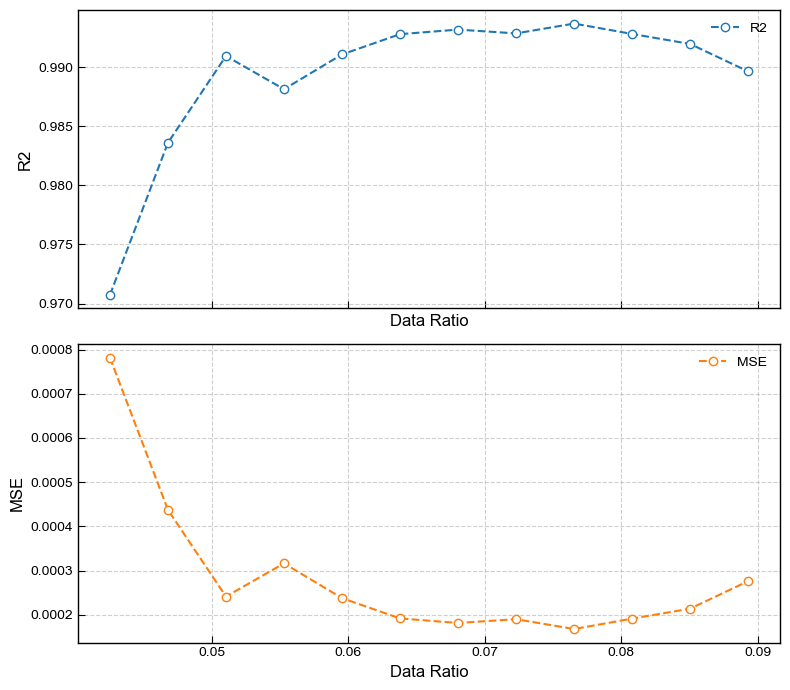

In [25]:
fig, axs = plt.subplots(2,1, figsize=(8,7),sharex=True)

axs[0].plot(performance['data_ratio'],
         performance['R2'],
         color=plot_params.colors[0],
         marker='o',
         markersize=6,
         linestyle='--',
         markerfacecolor='white',
         markeredgecolor=plot_params.colors[0],
         label='R2')

axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].set_xlabel('Data Ratio')
axs[0].set_ylabel('R2')
axs[0].legend()

axs[1].plot(performance['data_ratio'],
         performance['MSE'],
         color=plot_params.colors[1],
         marker='o',
         markersize=6,
         linestyle='--',
         markerfacecolor='white',
         markeredgecolor=plot_params.colors[1],
         label='MSE')

axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].set_xlabel('Data Ratio')
axs[1].set_ylabel('MSE')
axs[1].legend()

plt.tight_layout()
plt.show()

### Visualize Selection

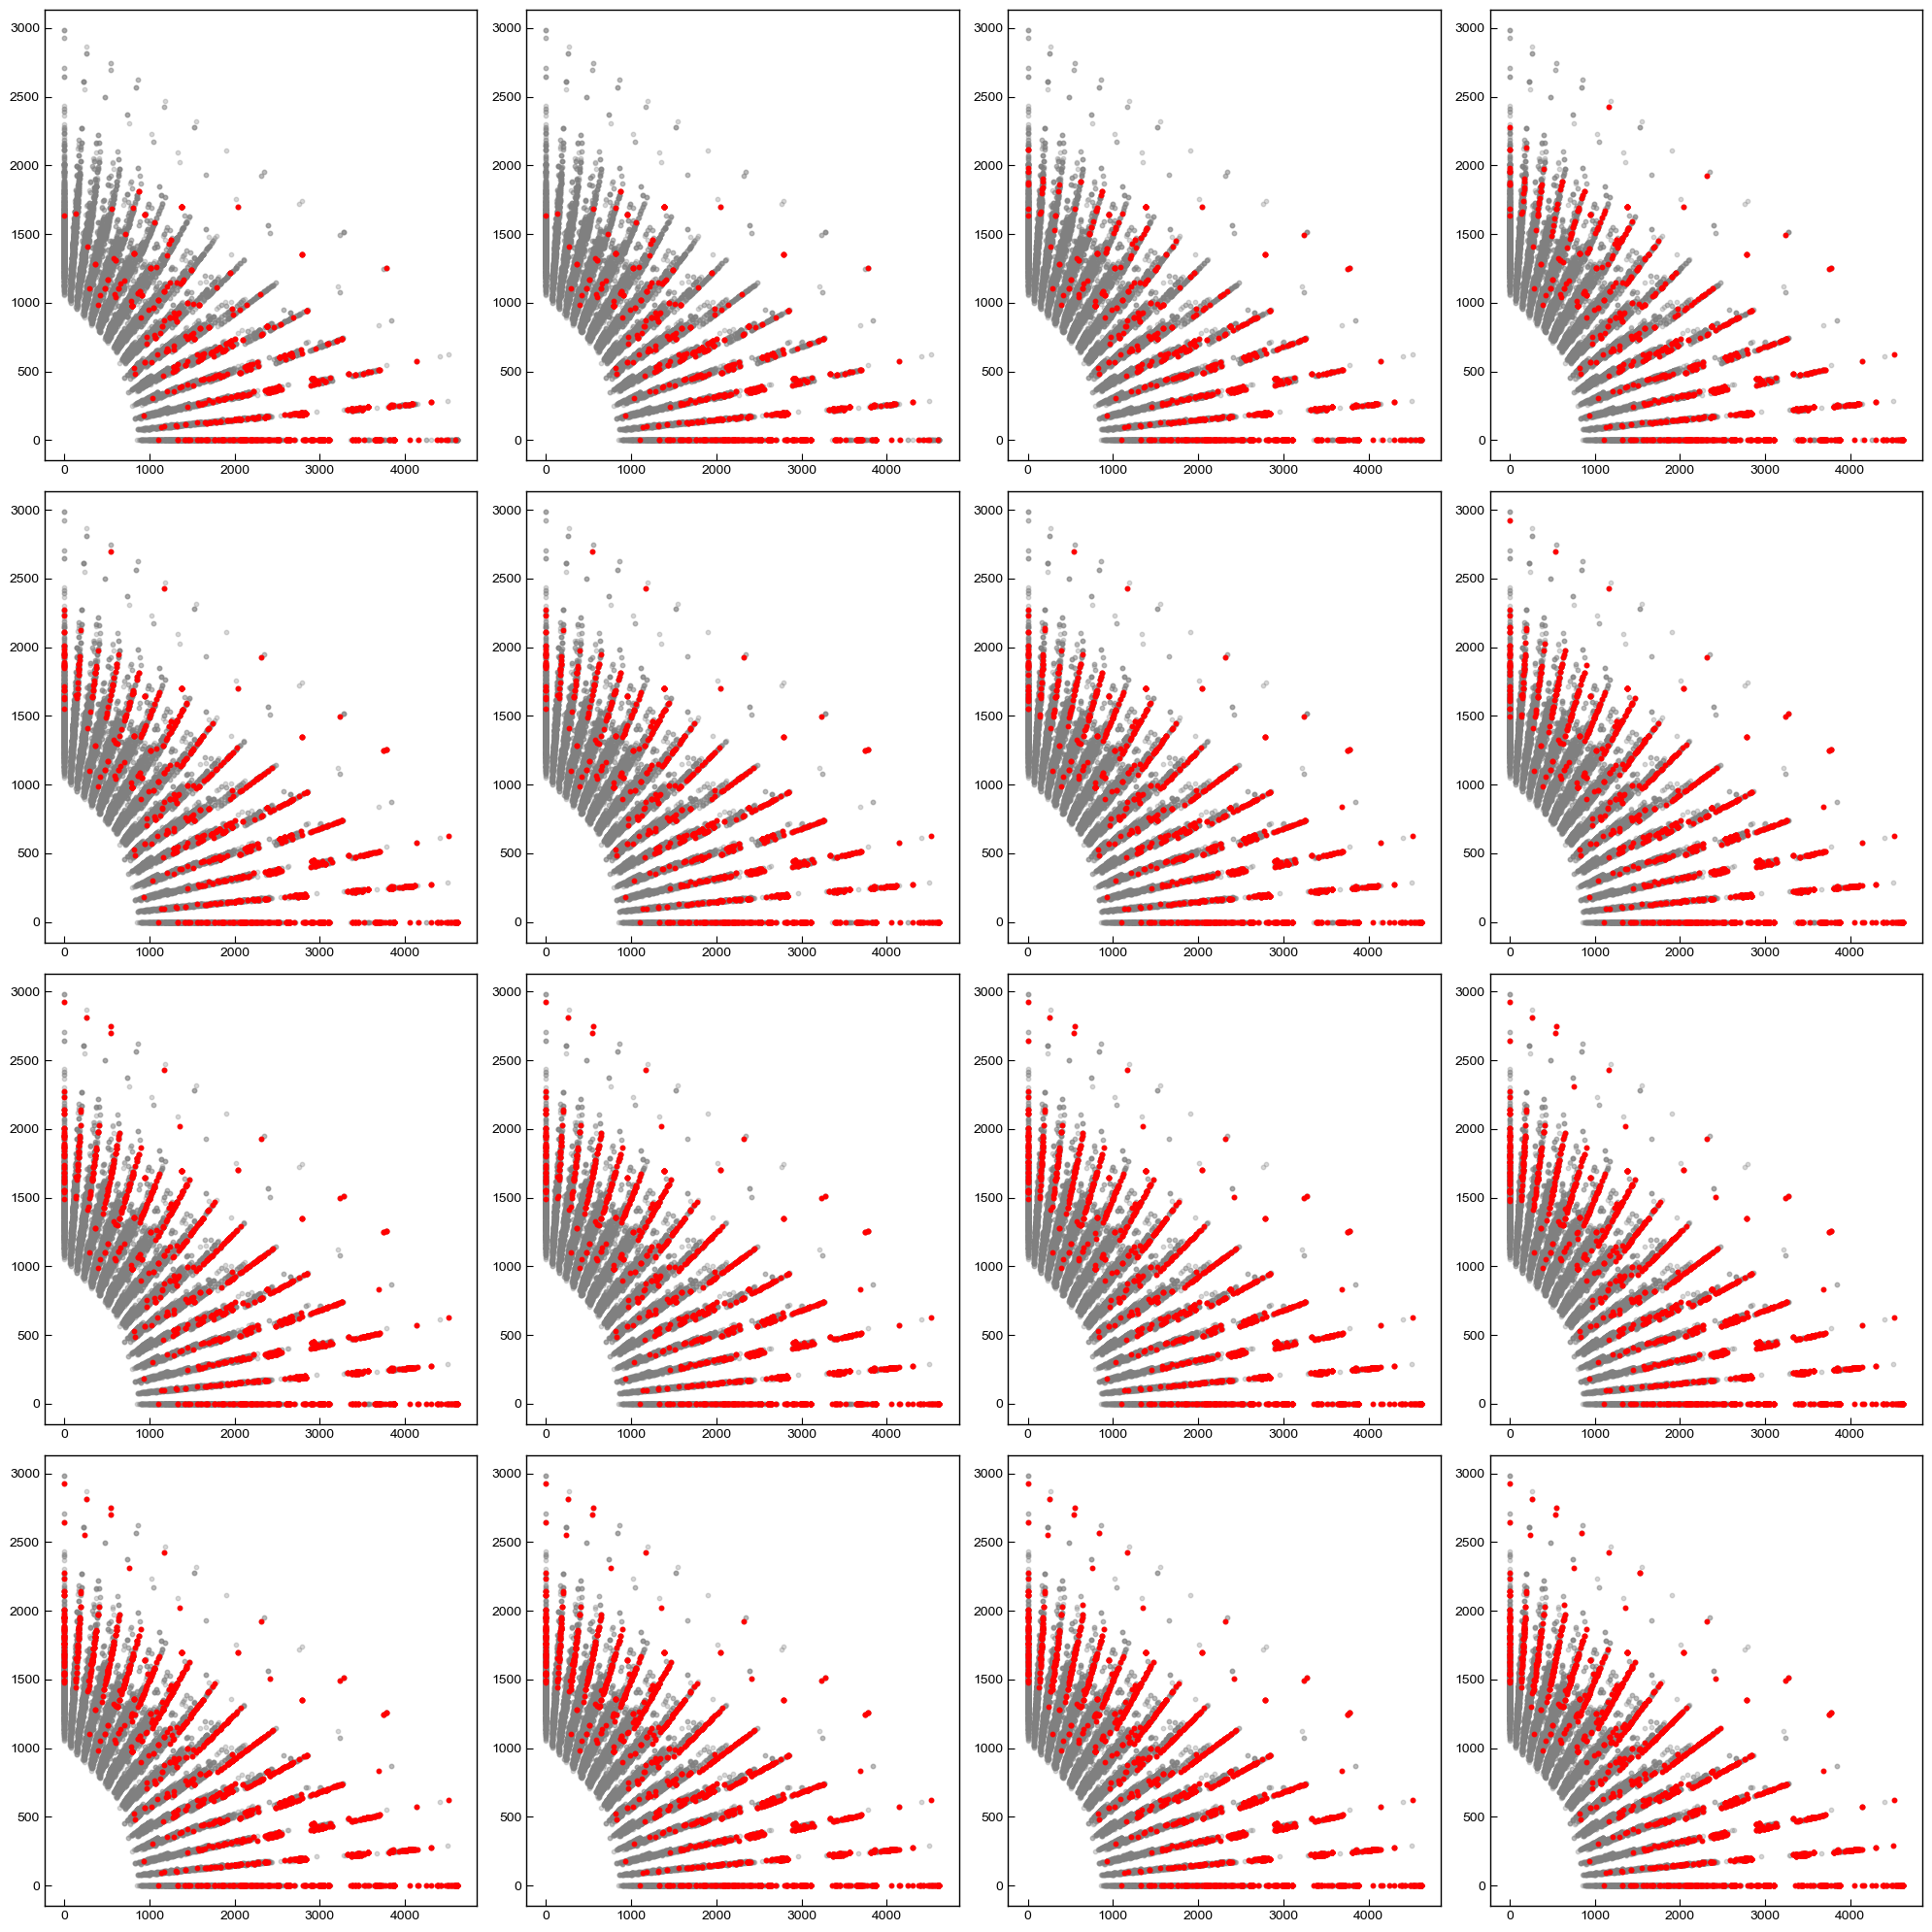

In [26]:
fig, axs = plt.subplots(4,4, figsize=(20,20))

n_iterations = len(performance['data_indeces'])

show_frame = np.linspace(0, n_iterations, 17, dtype=int)

for i in range(4):
    for j in range(4):
        df_selected = df.loc[performance['data_indeces'][show_frame[i*4+j]]]
        axs[i,j].scatter(df['M_Rd'], df['V_Rd'],
                         c='gray',
                         alpha=0.3,
                         label='Full Data',
                         s=10)
        axs[i,j].scatter(df_selected['M_Rd'], df_selected['V_Rd'],
                         c='r',
                         label='Selected Data',
                         s=10)
        
plt.tight_layout()
plt.show()

### PCA

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [28]:
X = df[model.features].values
y = df[model.target].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", np.cumsum(explained_variance))


Explained Variance Ratio: [0.58744688 0.12786738]
Cumulative Explained Variance: [0.58744688 0.71531426]


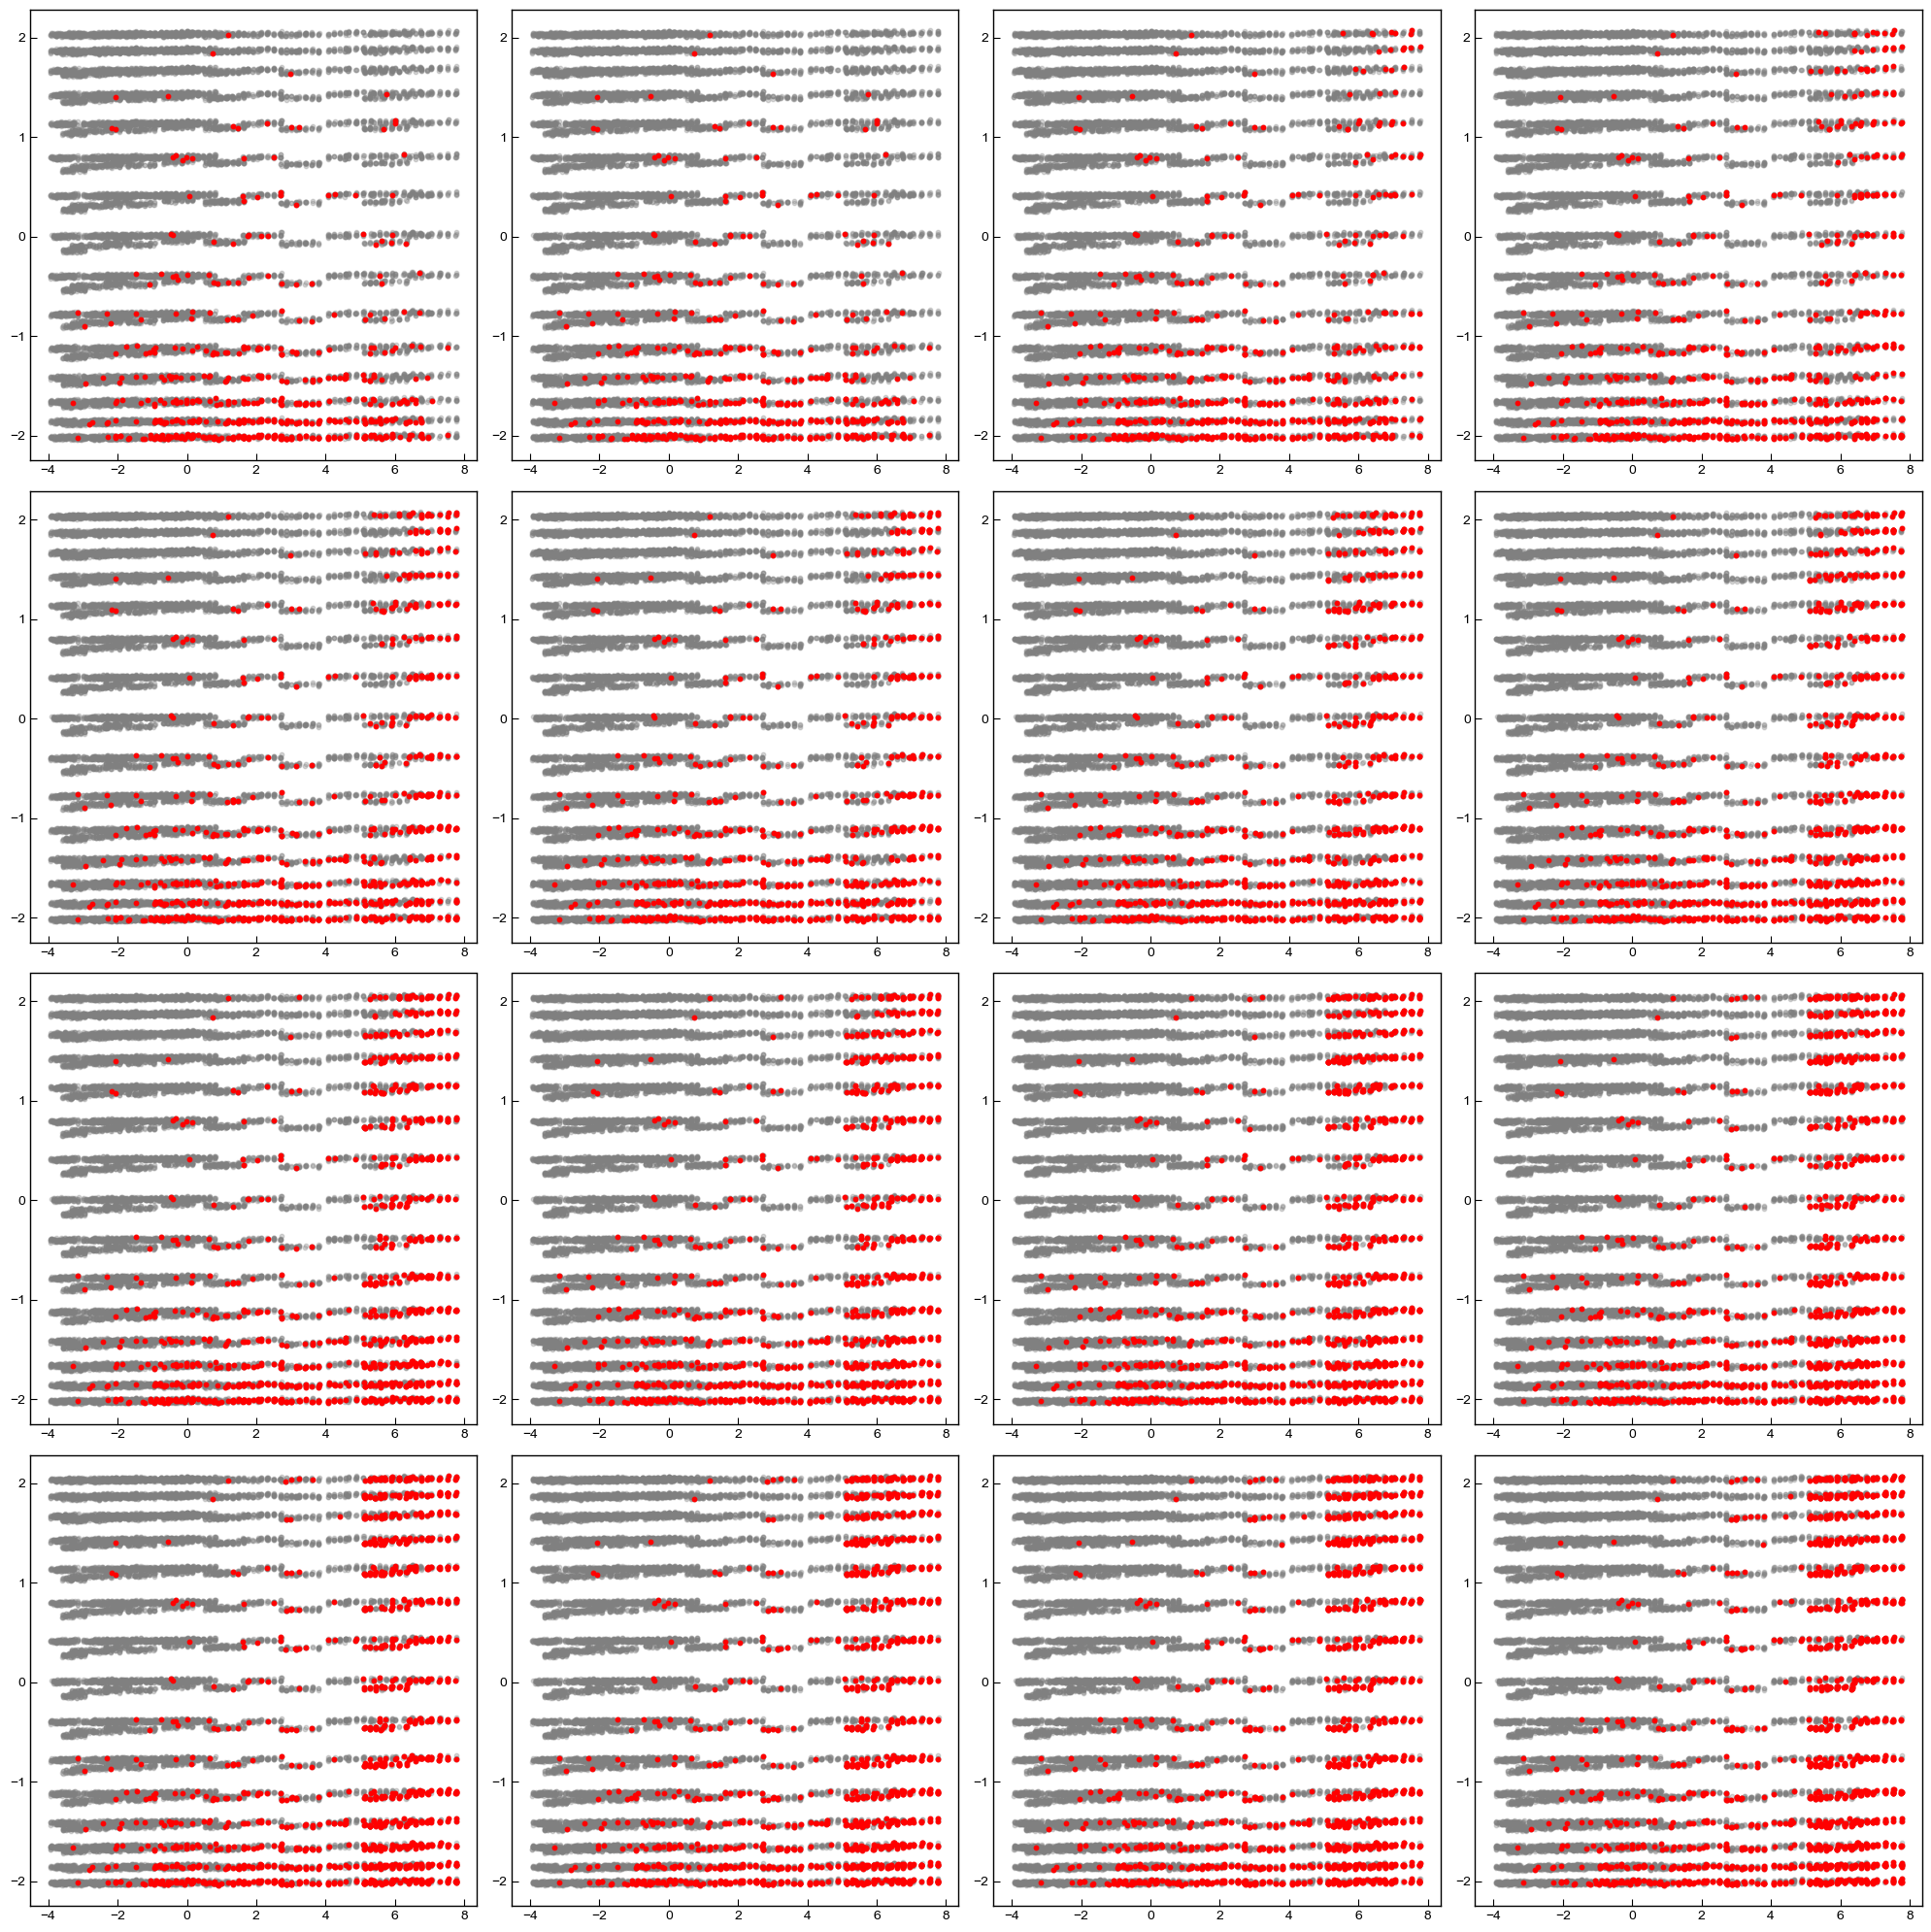

In [29]:
fig, axs = plt.subplots(4,4, figsize=(20,20))

n_iterations = len(performance['data_indeces'])

show_frame = np.linspace(0, n_iterations, 17, dtype=int)

for i in range(4):
    for j in range(4):
        data_indices = performance['data_indeces'][show_frame[i*4+j]]
        list_indices = np.where(np.isin(df.index, data_indices))[0]

        axs[i,j].scatter(X_pca[:,0], X_pca[:,1],
                         c='gray',
                         alpha=0.3,
                         label='Full Data',
                         s=10)
        axs[i,j].scatter(X_pca[:,0][list_indices], X_pca[:,1][list_indices],
                         c='r',
                         label='Selected Data',
                         s=10)
        
plt.tight_layout()
plt.show()

### Initiation Comparison

In [73]:
activeLearning = AL(model = model,
              method = None,
              df = df,
              init_strategy='kmeans',
              n_init_samples=100,
              fix_initial_df=False
)

** Available Methods **
error_based
MC_dropout_uncertainty
random_sampling
cluster_based
latin_hypercube
** Available Initiation Methods **
kmeans
latin_hypercube
max_min_distance
uncertainty_sampling
random_sampling


In [74]:
selected_data = {'method':[], 'data':[]}

for method in activeLearning.initiation_methods_available:
    print(method)
    activeLearning.init_strategy = method
    data = activeLearning.select_initial_data()

    selected_data['method'].append(method)
    selected_data['data'].append(data)

kmeans
latin_hypercube
max_min_distance
uncertainty_sampling
Number of training samples: 18816
Number of validation samples: 2351
Number of testing samples: 2351
random_sampling


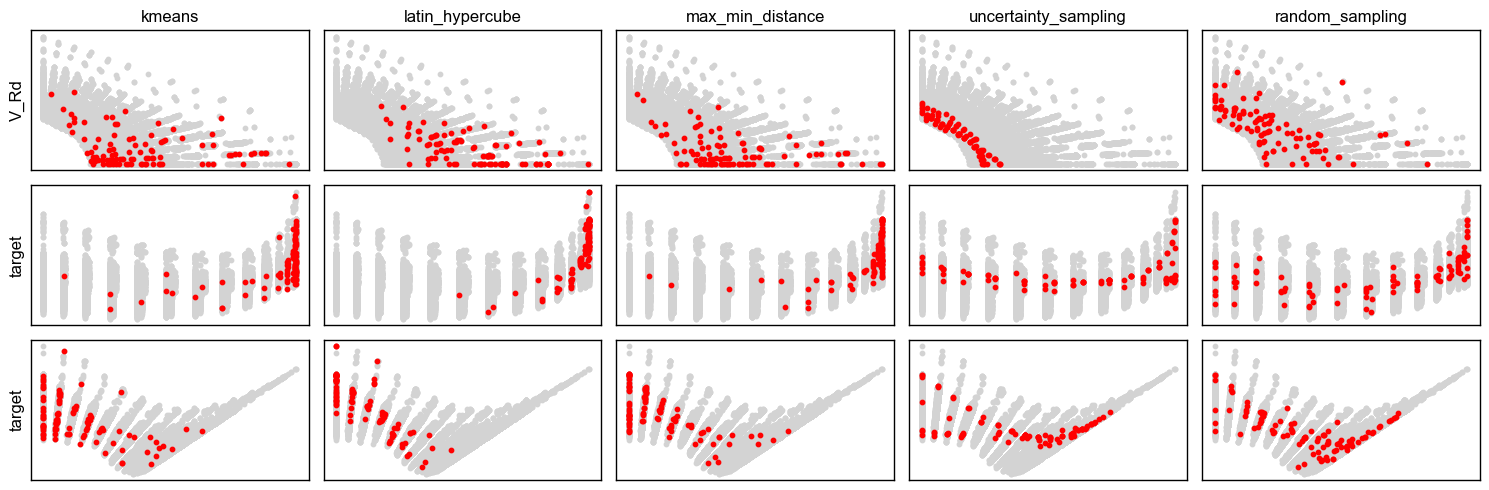

In [ ]:
fig, axs = plt.subplots(3,len(activeLearning.initiation_methods_available), figsize=(15,10))

for i,(method,data) in enumerate(zip(selected_data['method'], selected_data['data'])):
    selected_indices = data.index

    df_selected = df.loc[selected_indices]

    axs[0,i].scatter(df['M_Rd'], df['V_Rd'],
                    label='Full Data',
                    c='lightgray',
                    s=10)

    axs[0,i].scatter(df_selected['M_Rd'], df_selected['V_Rd'],
                    label='Selected Data',
                    c='r',
                    s=10)
    
    axs[0,i].set_title(method)

    axs[1,i].scatter(df['M_contribution'], df['target'],
                    label='Full Data',
                    c='lightgray',
                    s=10)
    
    axs[1,i].scatter(df_selected['M_contribution'], df_selected['target'],
                    label='Selected Data',
                    c='r',
                    s=10)
    
    axs[2,i].scatter(df['V_norm'], df['target'],
                    label='Full Data',
                    c='lightgray',
                    s=10)
    
    axs[2,i].scatter(df_selected['V_norm'], df_selected['target'],
                    label='Selected Data',
                    c='r',
                    s=10)
    
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])

axs[0,0].set_ylabel('V_Rd')
axs[1,0].set_ylabel('target')
axs[2,0].set_ylabel('target')

plt.tight_layout()
plt.show()

### Method Comparison

Here the performance of the **active learning methods** is tested. From the initial model condition (_seed_, _test/train/val split_, _model weights_) each active learning method is performed. To minimize dependance of the performance on the initial model conditions, each AL method is tested on $n$ iterations, with randomly varying initial conditions.

The performance metrics which are measure are:

- R2
- RMSE
- MCDUS (Monte Carlo Dropout Uncertainty Score)
- MCDMS (Monte Carlo Dropout Mean Score)

The tested **AL methods** are the following:

In [198]:
activeLearning.methods_available

['error_based',
 'minimize_MCD_uncertainty',
 'minimize_MCD_uncertainty_and_error',
 'random_sampling',
 'cluster_based',
 'latin_hypercube']

In [196]:
model.prepare_data(df)
model.build()

Number of training samples: 18814
Number of validation samples: 2352
Number of testing samples: 2352


In [ ]:
activeLearning = AL(model = model,
              method = 'error_based',
              df = df,
              init_strategy='latin_hypercube',
              n_init_samples=500,
              max_iterations=20,
              batch_size=50
            )

activeLearning.config['stopping_criteria'] = None
activeLearning.config['stopping_threshold'] = 1.0

iterations_per_method = 5 # How many times each method should be tested (to account for randomness)

** Available Methods **
error_based
minimize_MCD_uncertainty
minimize_MCD_uncertainty_and_error
random_sampling
cluster_based
latin_hypercube
** Available Initiation Methods **
kmeans
latin_hypercube
max_min_distance
random_sampling


In [167]:
model_sim = copy.deepcopy(model)

In [168]:
perf_comp_iter = {'method':[], 'iteration':[]}

for performance_metric in activeLearning.performance_template:
    perf_comp_iter[performance_metric] = []

In [169]:
for i in range(iterations_per_method):
    print(f"** Iteration {i+1}/{iterations_per_method} **")

    model_sim.config['seed'] = np.random.randint(0,1000)
    activeLearning.config['seed'] = np.random.randint(0,1000)
    activeLearning.df_initial = activeLearning.select_initial_data()
    
    model_sim.prepare_data(df)
    model_sim.build()

    activeLearning.model = model_sim

    for method in activeLearning.methods_available:
        print(f"**** Current method: {method} ****")
        activeLearning.method = method
        performance = activeLearning.trigger_active_learning()

        perf_comp_iter['method'].append(method)
        perf_comp_iter['iteration'].append(i)
        for metric,score in performance.items():
            perf_comp_iter[metric].append(score)

** Iteration 1/2 **
Number of training samples: 18814
Number of validation samples: 2352
Number of testing samples: 2352
**** Current method: error_based ****
Initial R² Score: 0.9070263355970383
Iteration 1: Training with 500 samples
    R² Score: 0.9502512402832508
Iteration 2: Training with 550 samples
    R² Score: 0.9693313539028168
Iteration 3: Training with 600 samples
    R² Score: 0.9789016470313072
Iteration 4: Training with 650 samples
    R² Score: 0.9735413938760757
Iteration 5: Training with 700 samples
    R² Score: 0.9679689407348633
Iteration 6: Training with 750 samples
    R² Score: 0.9738554954528809
Iteration 7: Training with 800 samples
    R² Score: 0.9711061958223581
Iteration 8: Training with 850 samples
    R² Score: 0.9780129492282867
Iteration 9: Training with 900 samples
    R² Score: 0.9783734790980816
Iteration 10: Training with 950 samples
    R² Score: 0.9791607949882746
Iteration 11: Training with 1000 samples
    R² Score: 0.9815218336880207
Iteration

In [ ]:
df_perf_comp_iter = pd.DataFrame(perf_comp_iter)

df_perf_comp_iter.to_pickle("AL_methods_performance_comparison.pkl")

'''
df_perf_comp_iter = pd.read_pickle("AL_methods_performance_comparison.pkl")
'''

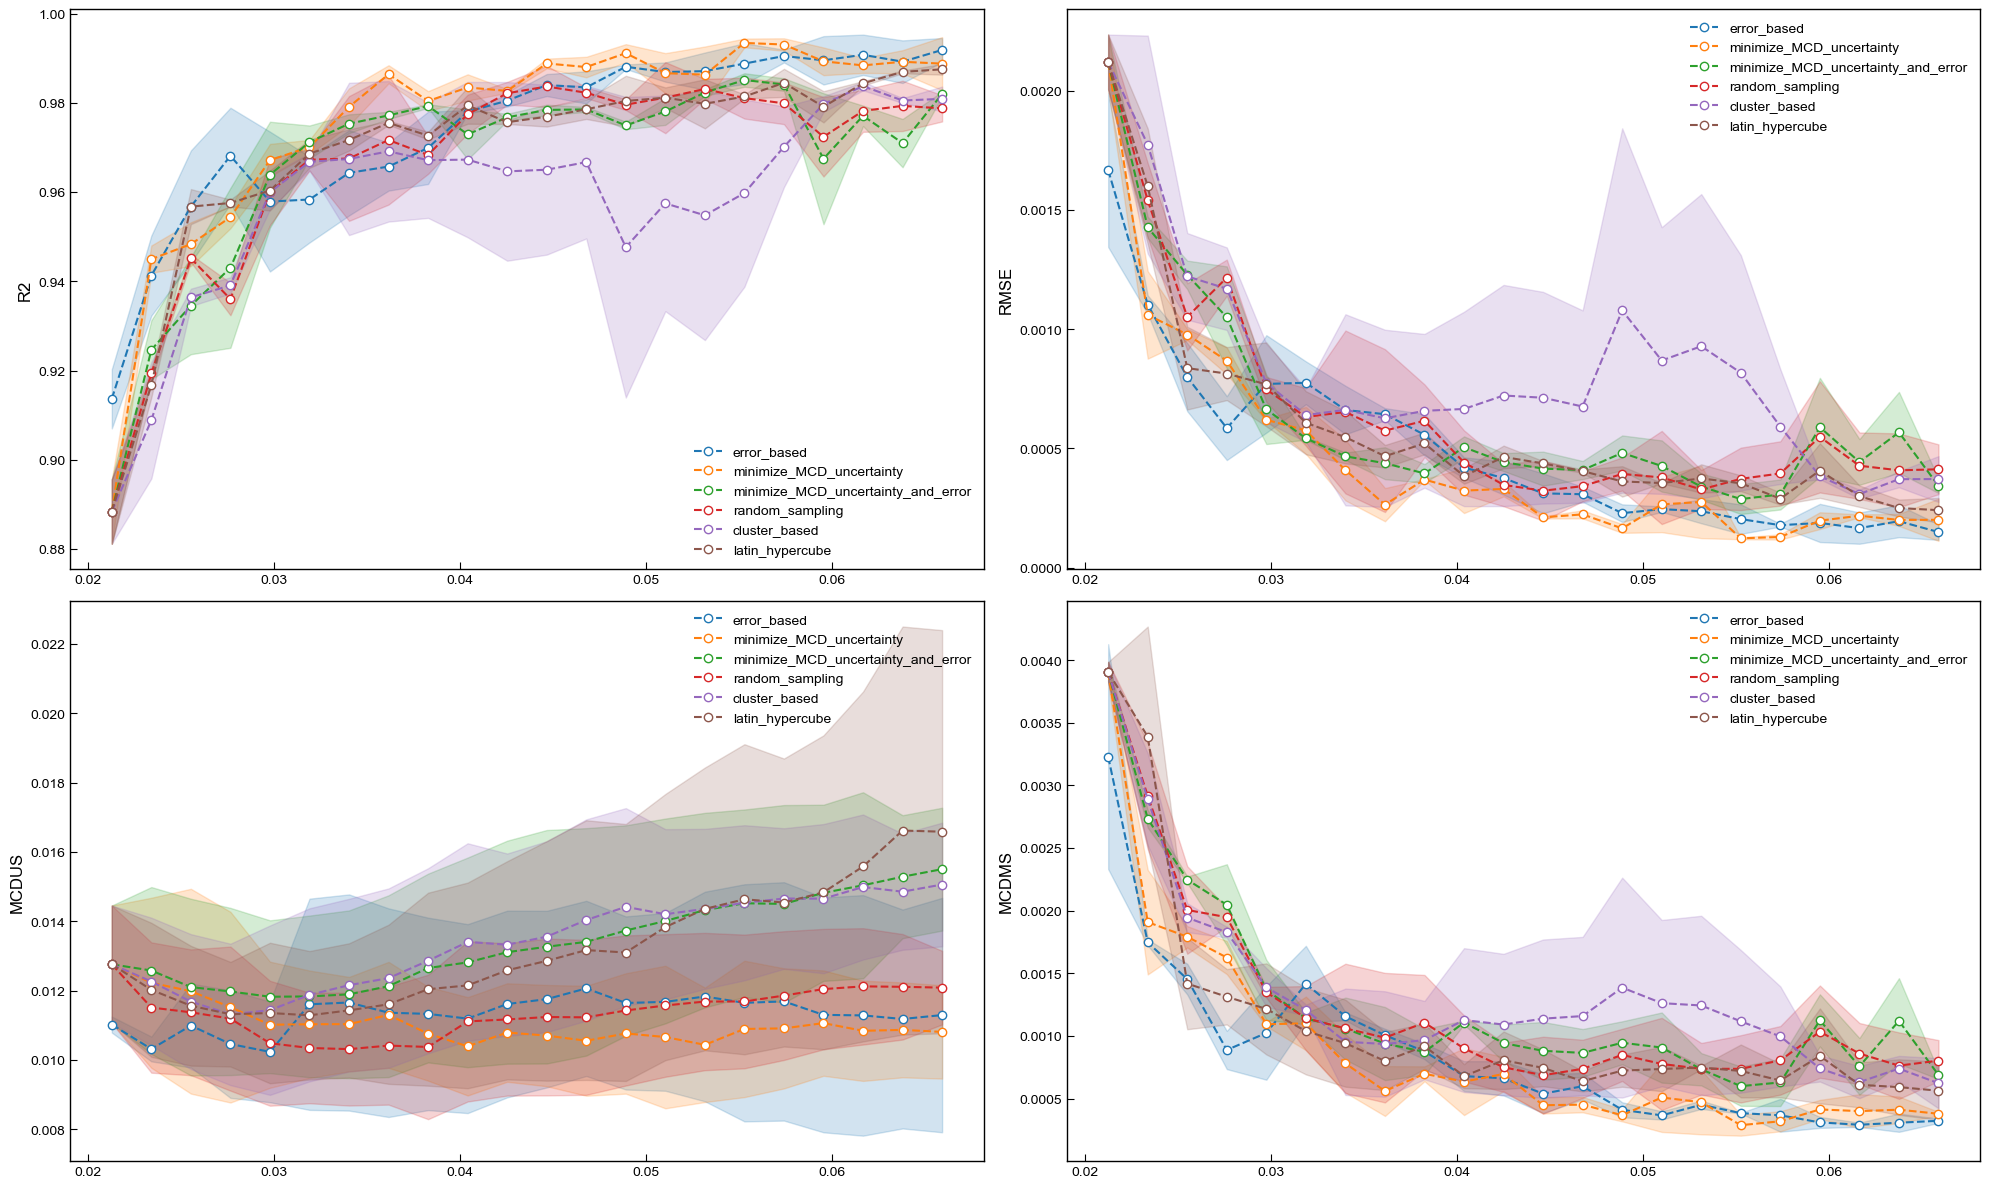

In [195]:
fig, axs = plt.subplots(2,2, figsize=(20,12))

for j,method in enumerate(df_perf_comp_iter['method'].unique()):
    df_method = df_perf_comp_iter[df_perf_comp_iter['method']==method]

    R2_values = np.column_stack(df_method['R2'].values)
    RMSE_values = np.column_stack(df_method['MSE'].values)
    MCDUS_values = np.column_stack(df_method['MCDUS'].values)
    MCDMS_values = np.column_stack(df_method['MCDMS'].values)
    data_ratio = np.column_stack(df_method['data_ratio'].values)

    R2_mean_values = R2_values.mean(axis=1)
    R2_std_values = R2_values.std(axis=1)

    RMSE_mean_values = RMSE_values.mean(axis=1)
    RMSE_std_values = RMSE_values.std(axis=1)

    MCDUS_mean_values = MCDUS_values.mean(axis=1)
    MCDUS_std_values = MCDUS_values.std(axis=1)

    MCDMS_mean_values = MCDMS_values.mean(axis=1)
    MCDMS_std_values = MCDMS_values.std(axis=1)

    axs[0,0].plot(data_ratio[:,0],
                  R2_mean_values,
                color=plot_params.morecolors[2*j],
                marker='o',
                markersize=6,
                linestyle='--',
                markerfacecolor='white',
                markeredgecolor=plot_params.morecolors[2*j],
                label=method,
                zorder=2)
    
    axs[0,0].fill_between(data_ratio[:,0],
                         R2_mean_values-R2_std_values,
                         R2_mean_values+R2_std_values,
                         color=plot_params.morecolors[2*j],
                         alpha=0.2,
                         zorder=0)
    
    axs[0,0].legend()
    axs[0,0].set_ylabel('R2')
    
    axs[0,1].plot(data_ratio[:,0],
                  RMSE_mean_values,
                color=plot_params.morecolors[2*j],
                marker='o',
                markersize=6,
                linestyle='--',
                markerfacecolor='white',
                markeredgecolor=plot_params.morecolors[2*j],
                label=method,
                zorder=2)
    
    axs[0,1].fill_between(data_ratio[:,0],
                         RMSE_mean_values-RMSE_std_values,
                         RMSE_mean_values+RMSE_std_values,
                         color=plot_params.morecolors[2*j],
                         alpha=0.2,
                         zorder=0)
    
    axs[0,1].legend()
    axs[0,1].set_ylabel('RMSE')
    
    axs[1,0].plot(data_ratio[:,0],
                  MCDUS_mean_values,
                color=plot_params.morecolors[2*j],
                marker='o',
                markersize=6,
                linestyle='--',
                markerfacecolor='white',
                markeredgecolor=plot_params.morecolors[2*j],
                label=method,
                zorder=2)
    
    axs[1,0].fill_between(data_ratio[:,0],
                         MCDUS_mean_values-MCDUS_std_values,
                         MCDUS_mean_values+MCDUS_std_values,
                         color=plot_params.morecolors[2*j],
                         alpha=0.2,
                         zorder=0)
    
    axs[1,0].legend()
    axs[1,0].set_ylabel('MCDUS')
    
    axs[1,1].plot(data_ratio[:,0],
                  MCDMS_mean_values,
                color=plot_params.morecolors[2*j],
                marker='o',
                markersize=6,
                linestyle='--',
                markerfacecolor='white',
                markeredgecolor=plot_params.morecolors[2*j],
                label=method,
                zorder=2)
    
    axs[1,1].fill_between(data_ratio[:,0],
                         MCDMS_mean_values-MCDMS_std_values,
                         MCDMS_mean_values+MCDMS_std_values,
                         color=plot_params.morecolors[2*j],
                         alpha=0.2,
                         zorder=0)
    
    axs[1,1].legend()
    axs[1,1].set_ylabel('MCDMS')

plt.tight_layout()
plt.show()

#### Full Grid

In [116]:
activeLearning = AL(model = model,
              method = 'error_based',
              df = df,
              init_strategy='latin_hypercube',
              n_init_samples=500,
              max_iterations=20,
              batch_size=100
            )

activeLearning.config['stopping_criteria'] = 'R2'
activeLearning.config['stopping_threshold'] = 0.95

** Available Methods **
error_based
MC_dropout_uncertainty
random_sampling
cluster_based
latin_hypercube
** Available Initiation Methods **
kmeans
latin_hypercube
max_min_distance
uncertainty_sampling
random_sampling


In [117]:
performance_full_grid = {'method':[], 'init_strategy': [], 'performance':[]}

performance_full_grid = pd.DataFrame(performance_full_grid)

In [119]:
for method in activeLearning.methods_available:
    for init_strategy in activeLearning.initiation_methods_available:
        print(f"Method: {method}, Init Strategy: {init_strategy}")
        activeLearning.method = method
        activeLearning.init_strategy = init_strategy
        performance = activeLearning.trigger_active_learning()
        new_entry = pd.DataFrame({'method': [method],
                                  'init_strategy': [init_strategy],
                                  'performance': [performance]})
        performance_full_grid = pd.concat([performance_full_grid, new_entry], ignore_index=True)

Method: error_based, Init Strategy: kmeans
Iteration 1: Training with 500 samples
    R² Score: 0.7720758467912674
Iteration 2: Training with 500 samples
    R² Score: 0.7720758467912674
Iteration 3: Training with 600 samples
    R² Score: 0.8458849340677261
Iteration 4: Training with 700 samples
    R² Score: 0.8479156345129013
Iteration 5: Training with 800 samples
    R² Score: 0.7559217512607574
Iteration 6: Training with 900 samples
    R² Score: 0.9236098900437355
Iteration 7: Training with 1000 samples
    R² Score: 0.9348304867744446
Iteration 8: Training with 1100 samples
    R² Score: 0.9312997832894325
Iteration 9: Training with 1200 samples
    R² Score: 0.8684200495481491
Iteration 10: Training with 1300 samples
    R² Score: 0.82181715965271
Iteration 11: Training with 1400 samples
    R² Score: 0.9527788050472736
Stopping criteria reached: R2 > 0.95
Method: error_based, Init Strategy: latin_hypercube
Iteration 1: Training with 500 samples
    R² Score: 0.7720758467912674

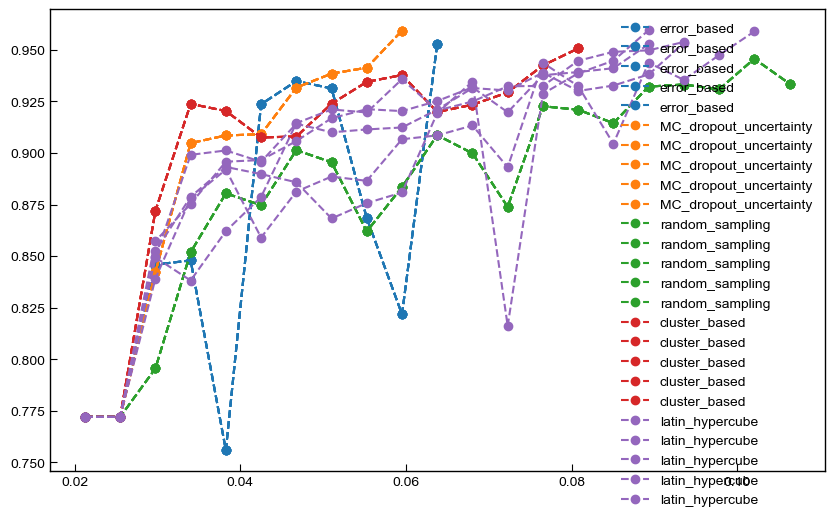

In [137]:
fig, ax = plt.subplots(figsize=(10,6))
for i,row in performance_full_grid.iterrows():
    method = row['method']
    init_strategy = row['init_strategy']
    performance = row['performance']

    method_index = activeLearning.methods_available.index(method)
    init_strategy_index = activeLearning.initiation_methods_available.index(init_strategy)
    
    plt.plot(performance['data_ratio'],
             performance['R2'],
             marker='o',
             markersize=6,
             linestyle='--',
             markerfacecolor=plot_params.colors[method_index],
             c=plot_params.colors[method_index],
             label=f"{method}")
    
plt.legend()
plt.show()

In [138]:
performance_matrix = np.zeros((len(activeLearning.methods_available), len(activeLearning.initiation_methods_available)))

for i,row in performance_full_grid.iterrows():
    performance = row['performance']
    method = row['method']
    init_strategy = row['init_strategy']

    method_index = activeLearning.methods_available.index(method)
    init_strategy_index = activeLearning.initiation_methods_available.index(init_strategy)

    performance_matrix[method_index, init_strategy_index] = performance['R2'][-1]


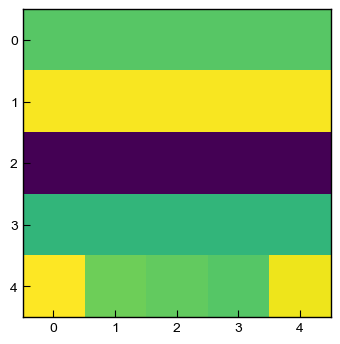

In [139]:
plt.imshow(performance_matrix)

### Inverse Active Learning

Inverse AL will iteratetively remove data analogously to the AL methods.

**Work in Progress**

In [51]:
AL_pingpong = AL(model = model,
                 method = 'error_based',
                 df = df,
                 initial_ratio = 0.01,
                 final_ratio = 0.2,
                 max_iterations = 5)

performance_pingpong = AL_pingpong.trigger_active_learning()

TypeError: ActiveLearning.__init__() got an unexpected keyword argument 'initial_ratio'

In [110]:
AL_pingpong.inverse = True
AL_pingpong.df_inital = df.loc[performance_pingpong['data_indeces'][-1]]
AL_pingpong.inverse_batch_size = 20
len(AL_pingpong.df_inital)

4700

In [111]:
changes = 2

for i in range(changes):
    AL_pingpong.inverse = True
    AL_pingpong.df_inital = df.loc[performance_pingpong['data_indeces'][-1]]

    performance_pingpong_new = AL_pingpong.trigger_active_learning()

    for line in performance_pingpong_new:
        performance_pingpong[line] = performance_pingpong[line] + performance_pingpong_new[line]

    AL_pingpong.inverse = False
    AL_pingpong.df_inital = df.loc[performance_pingpong['data_indeces'][-1]]
    performance_pingpong_new = AL_pingpong.trigger_active_learning()
    

Iteration 1: Training with 4700 samples
    R² Score: 0.9812327865511179
Iteration 2: Training with 3807 samples
    R² Score: 0.9622552692890167
Iteration 3: Training with 2914 samples
    R² Score: 0.9499498903751373
Iteration 4: Training with 2021 samples
    R² Score: 0.8784953281283379
Iteration 5: Training with 1128 samples
    R² Score: 0.8658108115196228
Iteration 1: Training with 1128 samples
    R² Score: 0.8824580237269402
Iteration 2: Training with 2021 samples
    R² Score: 0.883377879858017
Iteration 3: Training with 2914 samples
    R² Score: 0.9472090862691402
Iteration 4: Training with 3807 samples
    R² Score: 0.9614953920245171
Iteration 5: Training with 4700 samples
    R² Score: 0.9733450021594763
Iteration 6: Training with 5593 samples
    R² Score: 0.9738119523972273
Iteration 1: Training with 1128 samples
    R² Score: 0.8551800847053528
Iteration 1: Training with 1128 samples
    R² Score: 0.8774820640683174
Iteration 2: Training with 2021 samples
    R² Score

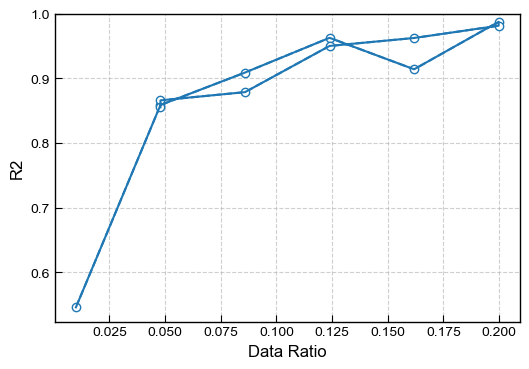

In [112]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(performance_pingpong['data_ratio'], performance_pingpong['R2'], 
         color=plot_params.colors[0],
         marker='o',
         markersize=6,
         linestyle='--',
         markerfacecolor='white',
         markeredgecolor=plot_params.colors[0],
         label='R2')

plt.plot(performance_pingpong['data_ratio'], performance_pingpong['R2'])

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Data Ratio')
plt.ylabel('R2')

plt.ylim([None,1.0])

plt.show()

### Forward/Inverse Iteration

Repeat the forward and inverse AL on the same data set.

TODO

## OLD

### Test All

In [ ]:
activeLearning = AL(model=model,
                    method=None,
                    df=df,
                    initial_ratio=0.01,
                    final_ratio=0.1,
                    max_iterations=10, 
                    fix_initial_df=True)

iterations_per_method = 3

performances = {}

for method in activeLearning.methods_available:

    print('****** Method:', method, '******')

    for i in range(iterations_per_method):

        print('Iteration:',
              i+1, '/', iterations_per_method)
    
        AL_sim = copy.copy(activeLearning)
        AL_sim.method = method

        performances[f"{method}-{i}"] = AL_sim.trigger_active_learning()

** Available Methods **
error_based
MC_dropout_uncertainty
random_sampling
cluster_based
latin_hypercube
****** Method: error_based ******
Iteration: 1 / 5
Iteration 1: Training with 235 samples
    R² Score: 0.5369601249694824
Iteration 2: Training with 446 samples
    R² Score: 0.7730967849493027
Iteration 3: Training with 657 samples
    R² Score: 0.8728665709495544
Iteration 4: Training with 868 samples
    R² Score: 0.8123131394386292
Iteration 5: Training with 1079 samples
    R² Score: 0.9000015556812286
Iteration 6: Training with 1290 samples
    R² Score: 0.914953887462616
Iteration 7: Training with 1501 samples
    R² Score: 0.8890941739082336
Iteration 8: Training with 1712 samples
    R² Score: 0.9034285321831703
Iteration 9: Training with 1923 samples
    R² Score: 0.9182268008589745
Iteration 10: Training with 2134 samples
    R² Score: 0.9500040598213673
Iteration 11: Training with 2345 samples
    R² Score: 0.9150161370635033
Iteration: 2 / 5
Iteration 1: Training with 

In [ ]:
df_performances = pd.DataFrame(performances).T

In [ ]:
df_performances 

In [ ]:


methods = df_performances['method'].unique()

fig, ax = plt.subplots(figsize=(10, 6))

for i,method in enumerate(methods):

    df_method = df_performances[df_performances[method]==method]

    for j,row in df_method.iterrows():
        plt.plot(row['data_ratio'],
                 row['R2'],
                 color=plot_params.morecolors[i],
                 marker='o',
                 markersize=5,
                 linestyle='None')

    plt.plot(df_method['data_ratio'],
             df_method['R2'].mean(),
             color=plot_params.morecolors[i],
             linestyle='--',
             alpha=0.3)


TypeError: 'int' object is not subscriptable

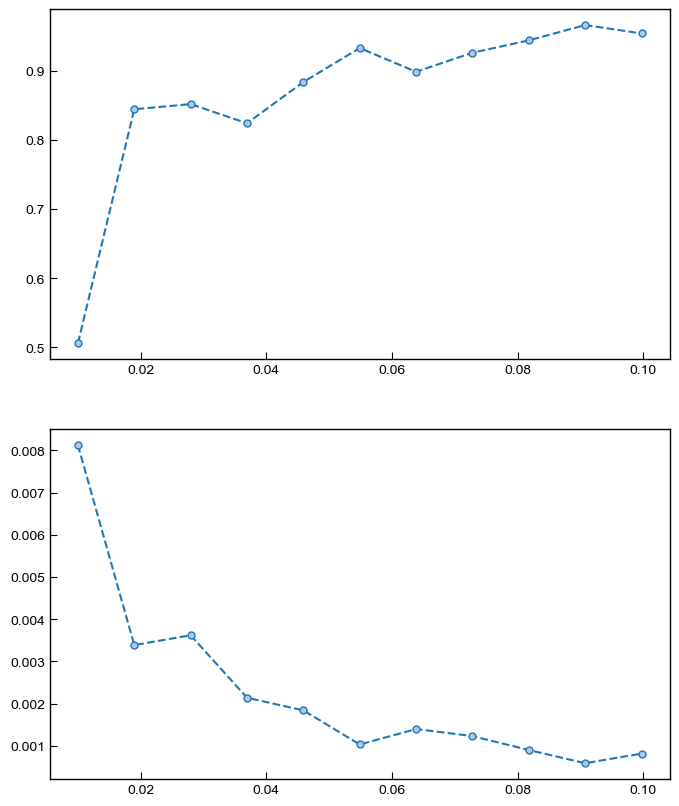

In [319]:
fig, axs = plt.subplots(2,1,figsize=(8, 10))

for i, (method, performance) in enumerate(performances.items()):
    R2 = performance['R2']
    MSE = performance['MSE']
    data_ratio = performance['data_ratio']

    axs[0].plot(data_ratio, R2,
            color = plot_params.morecolors[2*i],
            marker='o',
            markersize=5,
            linestyle='--',
            markeredgecolor=plot_params.morecolors[2*i], 
            markerfacecolor=plot_params.morecolors[2*i+1],
            label=method)
    
    axs[1].plot(data_ratio, MSE,
            color = plot_params.morecolors[2*i],
            marker='o',
            markersize=5,
            linestyle='--',
            markeredgecolor=plot_params.morecolors[2*i], 
            markerfacecolor=plot_params.morecolors[2*i+1],
            label=method)
    
axs[0].grid(True, which='both', linestyle='--', linewidth=1.0)
axs[0].set_xlabel('Data Ratio')
axs[0].set_ylabel('R2')
axs[0].legend()

axs[1].grid(True, which='both', linestyle='--', linewidth=1.0)
axs[1].set_xlabel('Data Ratio')
axs[1].set_ylabel('MSE')
axs[1].legend()

plt.show()

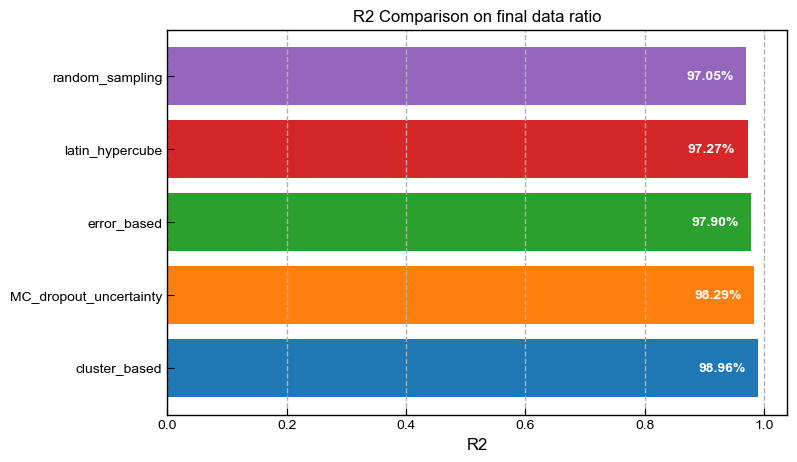

In [247]:
fig, ax = plt.subplots(1,1,figsize=(8, 5))

R2_final = np.array([performance['R2'][-1] for performance in performances.values()])
MSE_final = np.array([performance['MSE'][-1] for performance in performances.values()])
method_names = list(performances.keys())
data_ratio = list(performances.values())[0]['data_ratio']

order = np.argsort(R2_final)[::-1]
R2_final = R2_final[order]
MSE_final = MSE_final[order]
method_names = [method_names[i] for i in order]

plt.barh(method_names, R2_final, color=plot_params.colors[0:len(R2_final)], label='R2')
plt.grid(True, axis='x', linestyle='--', linewidth=1.0)

for i, v in enumerate(R2_final):
    ax.text(v-0.1, i, f'{100*v:.2f}%', 
            color='white', 
            va='center',
            weight='bold',
            fontsize=10)
plt.xlabel('R2')

plt.title('R2 Comparison on final data ratio')
plt.show()

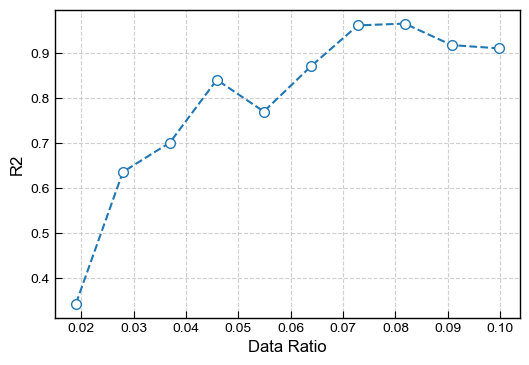

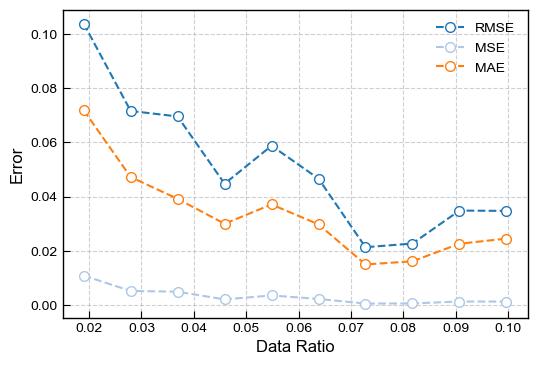

In [174]:
fig, ax = plt.subplots(figsize = (6,4))

plt.plot(performance['data_ratio'], performance['R2'], label = 'R2', 
        color = plot_params.morecolors[0],
        marker='o',
        markeredgecolor=plot_params.morecolors[0],
        markerfacecolor='white',
        markersize=7,
        linestyle='--')

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Data Ratio')
plt.ylabel('R2')

plt.show()

fig, ax = plt.subplots(figsize = (6,4))

plt.plot(performance['data_ratio'], performance['RMSE'], label = 'RMSE', 
        color = plot_params.morecolors[0],
        marker='o',
        markeredgecolor=plot_params.morecolors[0],
        markerfacecolor='white',
        markersize=7,
        linestyle='--')

plt.plot(performance['data_ratio'], performance['MSE'], label = 'MSE', 
        color = plot_params.morecolors[1],
        marker='o',
        markeredgecolor=plot_params.morecolors[1],
        markerfacecolor='white',
        markersize=7,
        linestyle='--')

plt.plot(performance['data_ratio'], performance['MAE'], label = 'MAE', 
        color = plot_params.morecolors[2],
        marker='o',
        markeredgecolor=plot_params.morecolors[2],
        markerfacecolor='white',
        markersize=7,
        linestyle='--')

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Data Ratio')
plt.ylabel('Error')

plt.legend()
plt.show()

## Plot

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

indeces = performances['cluster_based']['indeces']
df_reduced = df.iloc[indeces]

X_selected = df_reduced[model.features].values
X_full = df[model.features].values

scaler = StandardScaler()
X_selected_std = scaler.fit_transform(X_selected)
X_full_std = scaler.transform(X_full)

pca = PCA(n_components=2)

X_selected_pca = pca.fit_transform(X_selected_std)
X_full_pca = pca.transform(X_full_std)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

plt.scatter(X_full_pca[:,0], X_full_pca[:,1], 
            color=plot_params.morecolors[1], 
            s=1,
            label="Full Dataset")
plt.scatter(X_selected_pca[:,0], X_selected_pca[:,1], 
            color=plot_params.morecolors[0], 
            s=10,
            label="Selected Data")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

plt.show()

In [ ]:
# Set style
sns.set(style="whitegrid")

compare_features = ["A_x", "Iy_x", "Wely_x", "Wply_x", "fy_x",
            "A_y", "Iy_y", "Wely_y", "Wply_y", "fy_y",
            "Gamma", "Offset", "h_wid", "b_wid", "d_wid", "t_fwid", "t_wwid", 
            "t_stiffc", "V_contribution", "M_contribution"]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# Plot distributions for each column
for i, column in enumerate(compare_features):
    sns.kdeplot(df[column], label='Full Data', fill=True, alpha=0.5, ax=axes[i])
    sns.kdeplot(df_new[column], label='Selected Data', fill=True, alpha=0.5, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()